# Commodity mapping with openEO and CDSE

## 0. Installation

### Local 
Users that are running this notebook locally on their own machine are referred to the installation guide of the `World Agrocommodities` repository: https://github.com/masolele/WAC/blob/main/README.md

### CDSE Jupyterlab

Users can also choose to run this notebook in the CDSE Jupyterlab environment. In this method no local Python or Jupyter installation is required. https://dataspace.copernicus.eu/ecosystem/services/jupyterlab

In Jupyterlab users can select the `OpenEO` kernel and consequently install `World Agrocommodities` in the environment by running the cell below.

In [ ]:
## OPTIONAL: Install the WAC package with notebook dependencies

!pip install --no-deps "world_agrocommodities[notebooks] @ git+https://github.com/masolele/WAC.git"

## 1. Introduction

This notebook demonstrates how to:

- Select a spatial and temporal region using an interactive map.

- Query and retrieve a machine learning model from the STAC catalog.

- Run ML inference and visualize input and output data.

CDSE (Copernicus Data Space Ecosystem)
The CDSE is the platform hosting satellite imagery, processed data, and ML models. This notebook connects to the CDSE via OpenEO to fetch input data cubes and run processing jobs in the cloud. Make sure to create an account on the CDSE in order to be able to run this workflow: https://documentation.dataspace.copernicus.eu/Registration.html

New users to openEO are advised to first visit: https://github.com/Open-EO/openeo-community-examples/blob/main/python/1.%20GettingStarted/GettingStarted.ipynb


## 2. Interactive Spatial and Temporal Selection

Here the user can draw a bounding box (max 20kmx20km) and select a year via an interactive UI. This is the only step for which user interaction is required. Beyond this step, the user can just run all cells to run the inference and download the results. 

In [1]:
import world_agrocommodities.notebook.utility as utility

ui, result = utility.interactive_configurator()
ui

Loaded 3 model coverage areas
 Loaded 200 TCD coverage areas


In the example shown below, the following spatiotemporal extent was selected:

```
SPATIAL_EXTENT = {"crs": "EPSG:32736", "east": 604107.0810118779, "north": 7850915.7768229805, "south": 7844082.566892585, "west": 595996.6578205106}
TEMPORAL_EXTENT = ['2025-01-01', '2025-12-31']
```

## 3. Fetch Model Metadata

We have created a STAC collection which contains all relevant meta information for the available models for commodity mapping. Currently we have 3 models available; 1 for Africa, 1 for South America and one for South-East Asia. You can browse the catalogue at:

https://radiantearth.github.io/stac-browser/#/external/stac.openeo.vito.be/collections/world-agri-commodities-models?.language=en

each model is represented by an item. 

In the future we aim to expand this STAC collection and add meta-information on the accuracy of each model per commodity; thereby ensuring that our models and their performance is transparant. 

Below we query the STAC catalog for the ML model relevant to your region and period:

In [ ]:
from world_agrocommodities.model_stac import get_model_id, get_model_metadata

SPATIAL_EXTENT = result["spatial_extent"]
TEMPORAL_EXTENT = result["temporal_extent"]
CRS = SPATIAL_EXTENT[
    "crs"
]  # In this example, the output CRS is taken from spatial extent

model_id = get_model_id(SPATIAL_EXTENT, TEMPORAL_EXTENT)

model_metadata = get_model_metadata(model_id)
print(model_metadata)

STAC Item found:
  ID: WorldAgriCommodities_Africa_v1
Model metadata retrieved.
{'ModelID': None, 'Name': None, 'Region': 'Africa', 'Countries Covered': None, 'Framework': 'ONNX', 'Input Shape': 17, 'Output Shape': 25, 'Input Channels': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'NDVI', 'NDRE', 'EVI', 'VV', 'VH', 'DEM', 'lon', 'lat'], 'Output Classes': ['Background', 'Other_large_scale_cropland', 'Pasture', 'Mining', 'Other_small_scale_cropland', 'Roads', 'Forest', 'Plantation_forest', 'Coffee', 'Build_up', 'Water', 'Oil_palm', 'Rubber', 'Cacao', 'Avocado', 'Soy', 'Sugar', 'Maize', 'Banana', 'Pineapple', 'Rice', 'Wood_logging', 'Cashew', 'Tea', 'Others'], 'Time of Data begins': '2020-01-01T00:00:00Z', 'Time of Data ends': '2030-12-31T00:00:00Z'}


## 4. Run the classification inference workflow using openEO

Below we authenticate to the CDSE backend; as a first time user you will receive a https request to log-in when running `connection.authenticate_oidc()`. Ensure that you click the link, or log in through the web browser to continue. 

A utility function `map_commodities` has been created which builds the required openEO process graph from the interactactive UI and preset parameters defined in `config.py`. It is advised to not change the parameters set in the configuration file.

Running this cell will launch a job on the openEO backend and wait for it to finish.

In [2]:
from world_agrocommodities import map_commodities
import world_agrocommodities.classification.config as config
import openeo

connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()


pg = map_commodities(
    connection=connection,
    spatial_extent=SPATIAL_EXTENT,
    temporal_extent=TEMPORAL_EXTENT,
    model_id=model_id,
    crs=CRS,
).save_result(format="netcdf")

job = connection.create_job(
    title="Notebook example: WAC full processing pipeline",
    process_graph=pg,
    additional=config.JOB_OPTIONS,
)
job.start_and_wait()

Authenticated using refresh token.


Deriving band listing from unordered `item_assets`
The specified bands ['MAP'] in `load_stac` are not a subset of the bands [] found in the STAC metadata (unknown bands: ['MAP']). Working with specified bands as is.


0:00:00 Job 'j-25121810151446ffbc8106d51fbca29c': send 'start'
0:00:15 Job 'j-25121810151446ffbc8106d51fbca29c': created (progress 0%)
0:00:20 Job 'j-25121810151446ffbc8106d51fbca29c': created (progress 0%)
0:00:27 Job 'j-25121810151446ffbc8106d51fbca29c': created (progress 0%)
0:00:35 Job 'j-25121810151446ffbc8106d51fbca29c': created (progress 0%)
0:00:45 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:00:58 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:01:13 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:01:33 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:01:57 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:02:27 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:03:05 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:03:52 Job 'j-25121810151446ffbc8106d51fbca29c': running (progress N/A)
0:04:50 Job 'j-25121810151446ffbc8106d51fbca29c': running (progre

<BatchJob job_id='j-25121810151446ffbc8106d51fbca29c'>

# 5. Visualize Output Classification

Using the `utility` the classification results are downloaded (default directory `~/openeo_results/`) and shown in a plot.

Plotting mode: output


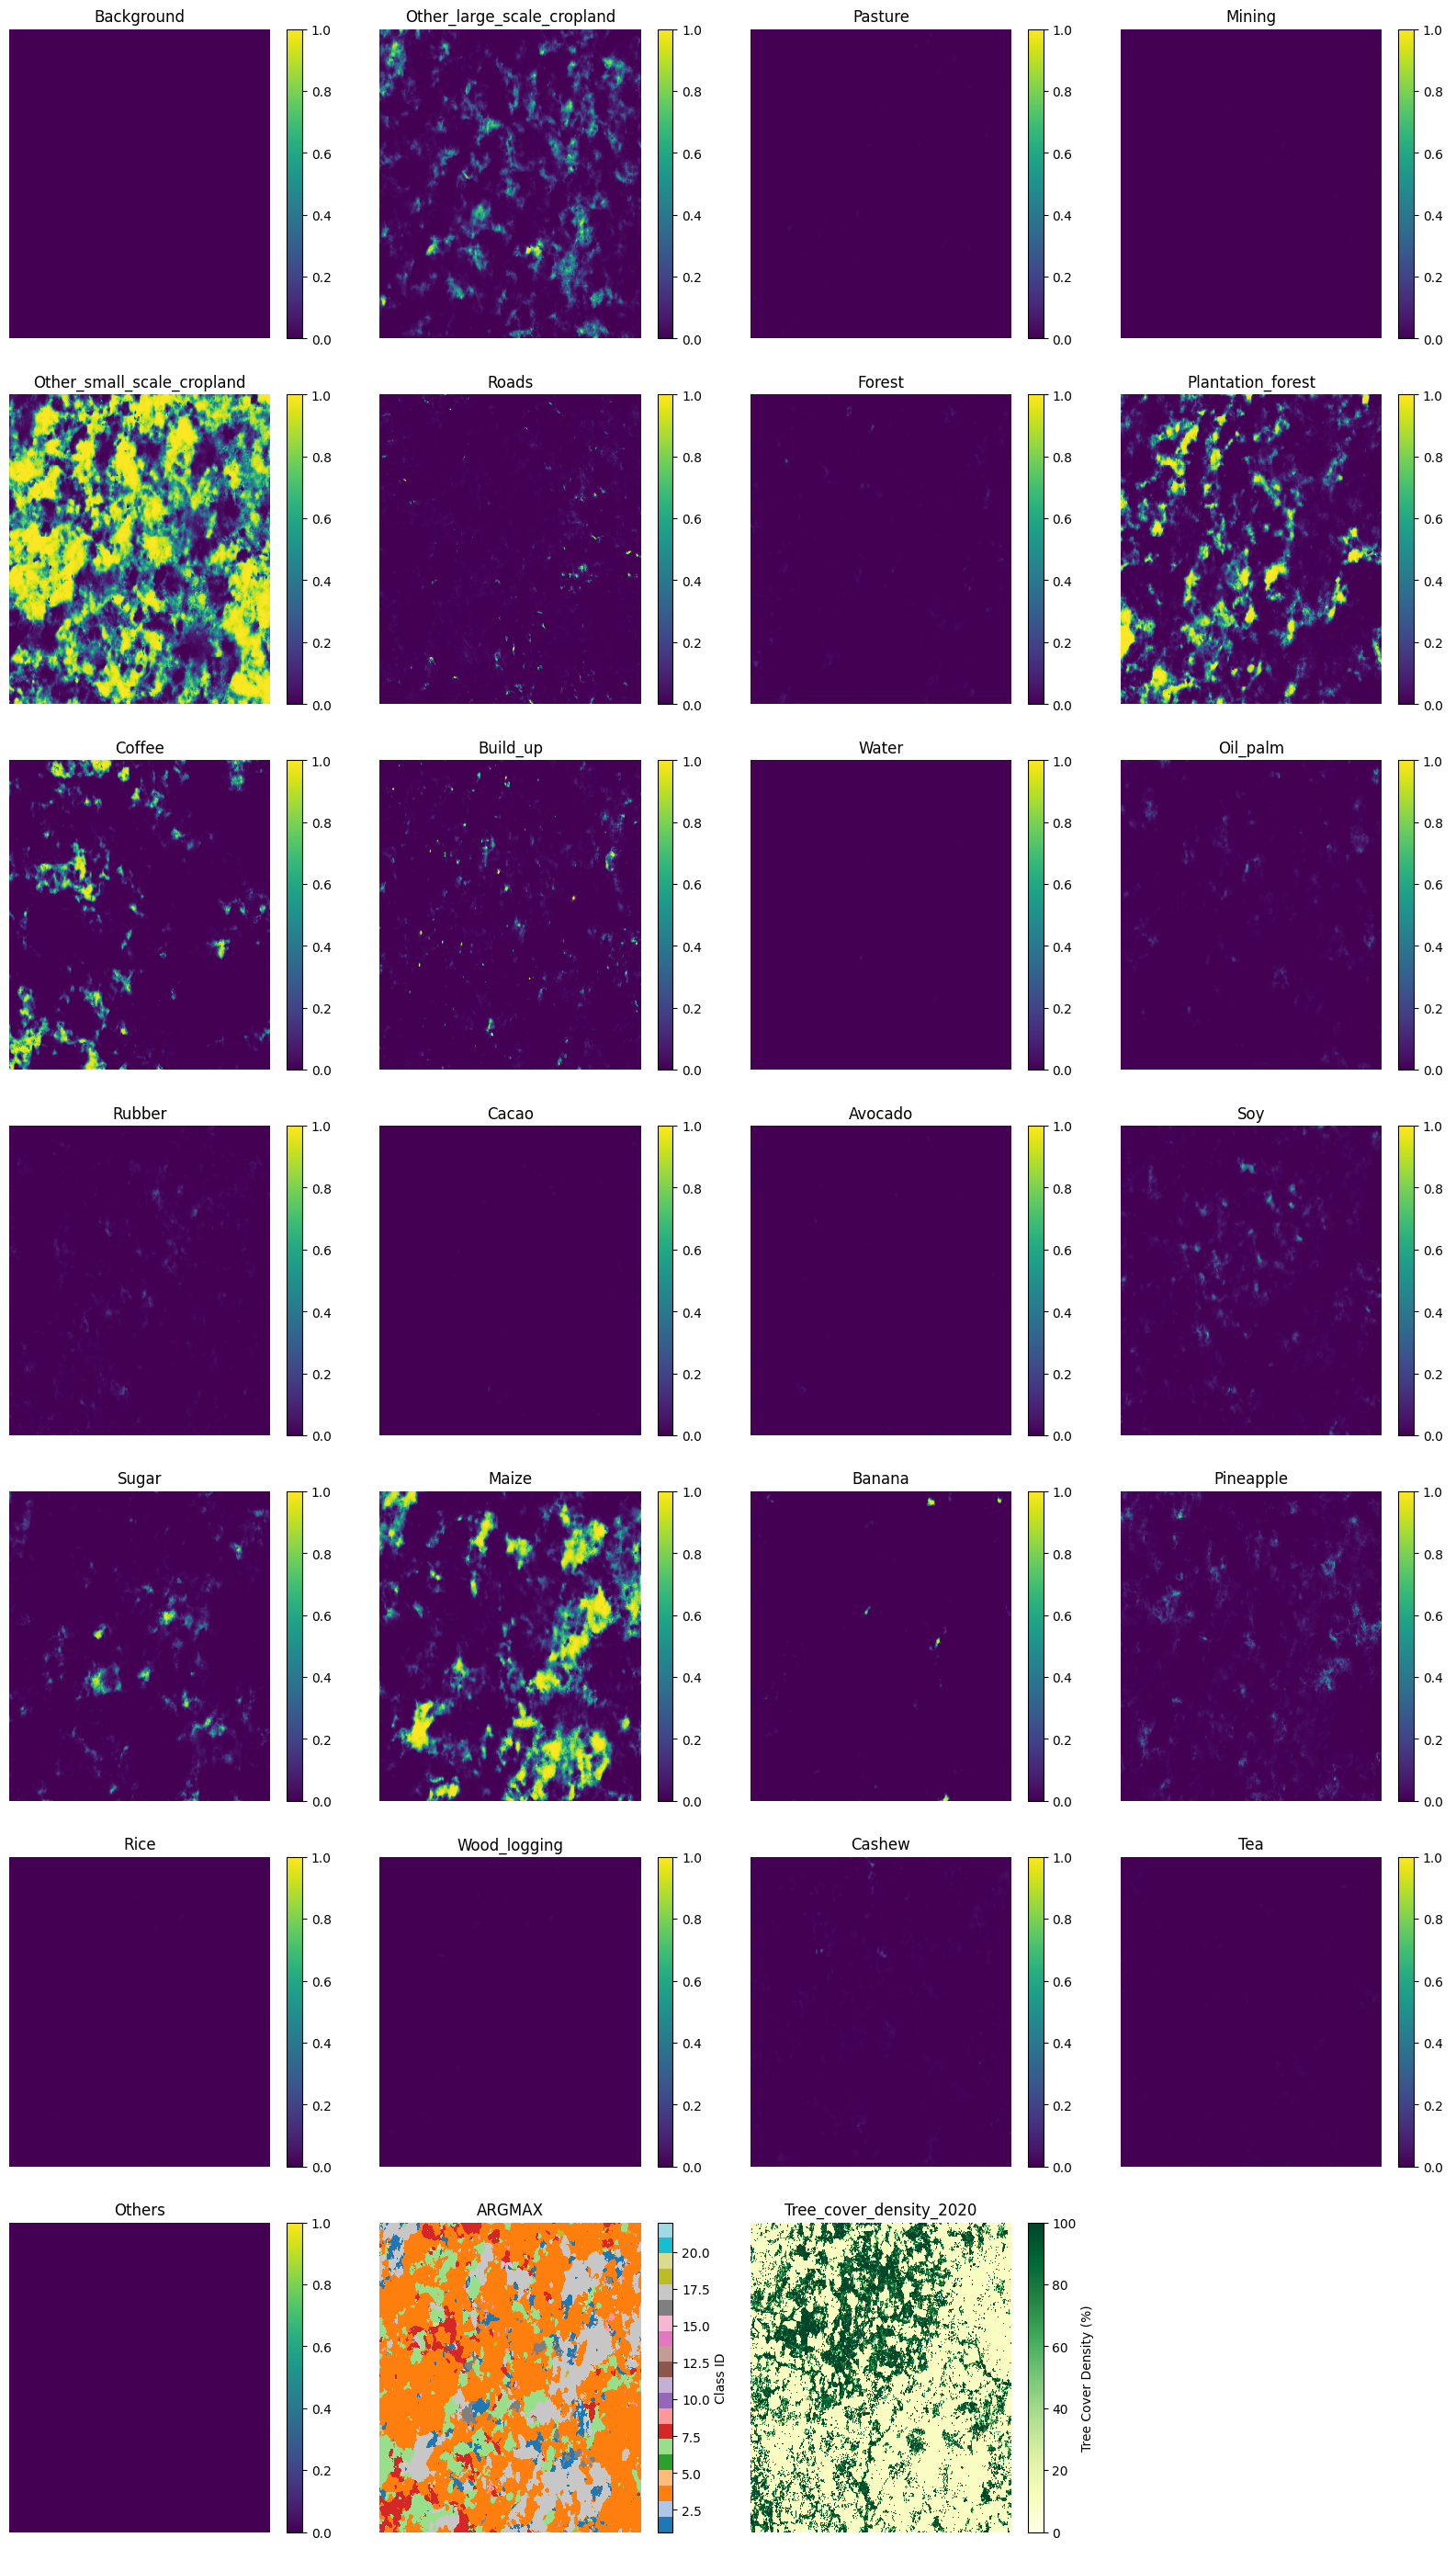

In [5]:
utility.plot_job_results(job, output_dir="~/openeo_results", time_step=0, mode="output")